# VaR and Credit Risk
## Value at Risk 

* The value at risk (VaR) of a portfolio is a function of two parameters (time horizon and confidence level) and it is used to asses to a certain precentage of confidence ($X$) how much will be the maximum loss in the next $N $days. 
    * It can be interpreted as the loss level over $N$ days that has a probability of only $(100 - X)\%$ of being exceeded.


* Mathematically the VaR is the loss corresponding to the $(100-X)\textrm{th}$ precentile of the distribution of the change in the value of the portfolio over the next $N$ days.
    * For example, with $N=1$ and $X=95$, VaR is the fifth percentile of the distribution of changes in the value of the portfolio over the next day 

<img src="normal_curve.png">


* VaR is useful to summarize all the information about the risk of a portfolio in one single number, but this can be also considered its main limitation (too much simplification).


* If the portfolio daily changes are normally distributed then:

$$\textrm{N-day VaR} = \textrm{1-day VaR}\times \sqrt{N}$$


## How to Estimate the VaR

* Input data [historical_data.csv](https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/historical_data.csv). 

In [8]:
# import historical data and add the return column
import pandas as pd
import numpy as np

data = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/historical_data.csv")

aapl = data.loc[:, 'aapl']
nflx = data.loc[:, 'nflx']

data['aapl_rets'] = aapl.pct_change()
data['nflx_rets'] = nflx.pct_change()

print (data.head())

         Date       aapl       nflx  aapl_rets  nflx_rets
0  2014-01-02  17.598297  51.831429        NaN        NaN
1  2014-01-03  17.211735  51.871429  -0.021966   0.000772
2  2014-01-06  17.305593  51.367142   0.005453  -0.009722
3  2014-01-07  17.181829  48.500000  -0.007152  -0.055817
4  2014-01-08  17.290642  48.712856   0.006333   0.004389


* In the following we will **assume to have a portfolio made of 60% of AAPL and 40% NFLX stocks**.

In [9]:
# define the weights of our portfolio

w = np.array([0.6, 0.4])

### Historical Simulation

* Collect the market variables affecting the portfolio over the last $N$ days (with $N$ quite large). 


* The variation over each day in our series will provide different scenarios to be applied to today's market data 

$$P_i(t_n+1) = P\Big(x_1(t_n)\frac{x_1(t_i)}{x_1(t_{i-1})} , x_2(t_n)\frac{x_2(t_i)}{x_2(t_{i-1})}\Big)$$


* Our VaR estimate will be the (100 - X)% percentile of the resulting distribution.


* Of course such historical simulation relies on the assumption that past behaviors are indicative of what might happen in the future.

#### Example

* Imagine a portfolio $P$ whose value depends only on ($x_1(t) = aapl(t), x_2(t)=nflx(t)$). 

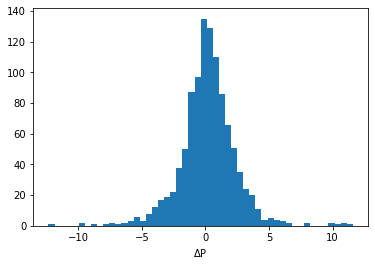

[-3.34964378]


In [55]:
# historical VaR
from matplotlib import pyplot as plt

# today's value
xN = [data['aapl'].iloc[-1], data['nflx'].iloc[-1]]
current_value = w.dot(xN)

#rets = []
#for i in range(1, len(aapl)):
#    rets.append(current_value*(w[0]*data['aapl_rets'].iloc[i] + 
#                               w[1]*data['nflx_rets'].iloc[i]))

rets = current_value * data.loc[1:, ['aapl_rets', 'nflx_rets']].dot(w)

plt.hist(rets, bins=50)
plt.xlabel("$\Delta$P")
plt.show()

print (np.percentile(rets, [5]))

### Monte Carlo Simulation
* A very useful alternative to the previous approach is using a Monte Carlo simulation to generate the probability distribution of the $\Delta P$.  Once we have the distribution of the returns the VaR can be computed as usual.


* The simulation can be done:
    1. generating random returns from a distribution with mean and standard deviation obtained from the historical data of each stock; 
    2. or by simulating the evolution of all the portfolio market variables in one day.

#### Case 1
* Compute mean and standard deviation of each historical data-set. 


* Then throw various simulated returns from a multivariate Gaussian with such means and variances. 
    * Useful aspect: other distribution could be used instead Gaussians.

[0.0008887944217690788, 0.0020063179213583673]
           aapl_rets  nflx_rets
aapl_rets   0.000207   0.000103
nflx_rets   0.000103   0.000718


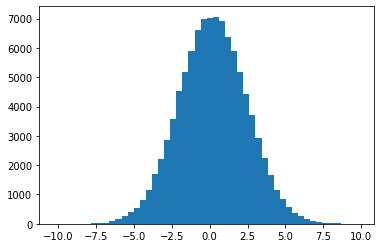

[-3.46081218]


In [59]:
# MC simulated VaR 1
from scipy.stats import multivariate_normal

np.random.seed(1)
means = [data['aapl_rets'].mean(), data['nflx_rets'].mean()]
cov = data.loc[1:, ['aapl_rets', 'nflx_rets']].cov()
print (means)
print (cov)
mvnorm = multivariate_normal(mean=means, cov=cov)
samples = 100000
x = mvnorm.rvs(size=samples)
#rets = []
#for x in rrets:
#    rets.append(current_value*(w.dot(x)))
rets = current_value*x.dot(w) 

plt.hist(rets, bins=50)
plt.show()
print (np.percentile(rets, [5]))

* This result can be compared with the VaR estimated with a simulation of the daily evolution of the stock price. 
    * We will use the log-normal evolution where $\mu$ and $\sigma$ are the mean and variance estimated from the historical series. 

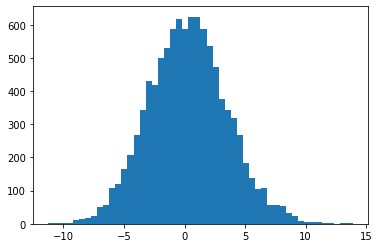

[-4.92050153]


In [64]:
from numpy.random import normal
from numpy import exp, sqrt

simulations = 10000
T = 1
rets = []
for _ in range(simulations):
    ret = 0
    for i in range(2):
        ret += w[i]*xN[i]*exp((means[i] - 0.5*cov.iloc[i][i])*T - sqrt(T)*sqrt(cov.iloc[i][i])*normal())
    rets.append(ret - current_value)
    
plt.hist(rets, bins=50)
plt.show()
print (np.percentile(rets, [5]))

### Stress Testing and Back Testing
* Usually it can be useful to perform a *stress test*. 
    * Implies to estimate how a portfolio would behave under the most extreme market moves seen in the past years.


* From the historical series take the market variables seen in particular days with exceptional large variations to analyze extreme events that can occur in reality more frequently than in simulations despite their low probability.
    * e.g. a 5-standard deviation move should happen once every 7000 years but in practice can be observed twice over 10 years.

In [44]:
# probability of having a 5-sigma event
from scipy.stats import norm

p = 1/(252*2*norm.cdf(-5))
print (p)

6921.737673091068


* Another important check that could be done is the *back testing* which consists of checking how well the VaR estimate would have performed in the past. 
    * it has to be tested how often the daily loss exceeded the N-days X% VaR just computed.
    * If it happens on about (100-X)% of the times we can be confident that our estimate is correct.